In [2]:
# !git clone -b geral https://github.com/wagner1986/singular-points.git singular_points
# !pip install kornia e2cnn

# !pwd
# %cd /content/singular_points
# !pwd

Cloning into 'singular_points'...
remote: Enumerating objects: 1408, done.
remote: Counting objects: 100% (244/244), done.
remote: Compressing objects: 100% (117/117), done.
remote: Total 1408 (delta 138), reused 224 (delta 121), pack-reused 1164
Receiving objects: 100% (1408/1408), 129.40 MiB | 11.44 MiB/s, done.
Resolving deltas: 100% (141/141), done.
Updating files: 100% (1196/1196), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 653.4/653.4 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.3/225.3 kB 21.0 MB/s eta 0:00:00
/content
/content/singular_points
/content/singular_points


In [3]:
import torch
from config import args, device
from predict.predict_utils import load_model_trained, predict_single_points
import torchvision
from torchvision.transforms import transforms, InterpolationMode
from utils.my_dataset import FibersDataset, WoodsDataset
from utils import create_circular_mask
from matplotlib import pyplot as plt
import numpy as np
torch.__version__

Using device: cpu


'2.0.0+cu118'

In [4]:
def custom_config(args):
    args.img_size = 180
    args.dim_first = 2
    args.dim_second = 3
    args.dim_third = 4
    args.batch_size = 8
    args.margin_loss = 2.0
    args.border  = 15
    args.exported = False
    return args

In [5]:
    args = custom_config(args)
    transform = transforms.Compose([
        transforms.Resize((args.img_size, args.img_size), interpolation=InterpolationMode.NEAREST),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    testset = torchvision.datasets.Flowers102(root='./data/datasets', split='test',
                                                download=True, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=args.batch_size,
                                             shuffle=False, num_workers=2)

100%|██████████| 344862509/344862509 [00:31<00:00, 11107617.60it/s]


Extracting data/datasets/flowers-102/102flowers.tgz to data/datasets/flowers-102


100%|██████████| 502/502 [00:00<00:00, 813264.04it/s]


100%|██████████| 14989/14989 [00:00<00:00, 21641453.58it/s]


In [6]:
from training import KeyEqGroup, KeyPointsSelection, remove_borders, random_augmentation, shifted_batch_tensor
from utils import load_model, imshow, imshow2, imshow3,NMSHead,get_features


MODEL_PATH = "./data/models/model_flowers_ssim.pt"

model = load_model_trained(args,device,path=MODEL_PATH)

/usr/local/lib/python3.10/dist-packages/e2cnn/nn/modules/r2_conv/basisexpansion_singleblock.py:80: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  full_mask[mask] = norms.to(torch.uint8)


Já foi treinado
epoca 39 loss 1.6361578539306043


In [7]:
iterator=iter(testloader)
batch = next(iterator)
img_batch, labels =batch
print(len(img_batch),labels) #4

8 tensor([0, 0, 0, 0, 0, 0, 0, 0])


pos predict  torch.Size([8, 1, 180, 180]) torch.Size([8, 36, 180, 180])


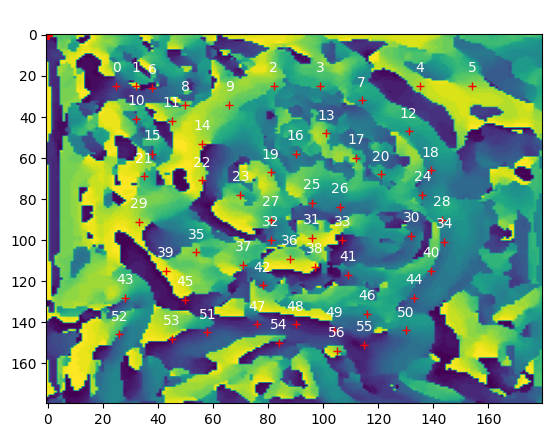

torch.Size([8, 180, 180]) torch.Size([8, 3, 71]) torch.Size([8, 71, 2])
torch.Size([180, 180]) [(15, 15), (36, 36)] torch.Size([21, 21])
torch.Size([180, 180]) [(22, 15), (43, 36)] torch.Size([21, 21])
torch.Size([180, 180]) [(72, 15), (93, 36)] torch.Size([21, 21])
torch.Size([180, 180]) [(89, 15), (110, 36)] torch.Size([21, 21])
torch.Size([180, 180]) [(125, 15), (146, 36)] torch.Size([21, 21])
torch.Size([180, 180]) [(144, 15), (165, 36)] torch.Size([21, 21])
torch.Size([180, 180]) [(28, 16), (49, 37)] torch.Size([21, 21])
torch.Size([180, 180]) [(104, 22), (125, 43)] torch.Size([21, 21])
torch.Size([180, 180]) [(40, 24), (61, 45)] torch.Size([21, 21])
torch.Size([180, 180]) [(56, 24), (77, 45)] torch.Size([21, 21])
torch.Size([180, 180]) [(22, 31), (43, 52)] torch.Size([21, 21])
torch.Size([180, 180]) [(35, 32), (56, 53)] torch.Size([21, 21])
torch.Size([180, 180]) [(121, 37), (142, 58)] torch.Size([21, 21])
torch.Size([180, 180]) [(91, 38), (112, 59)] torch.Size([21, 21])
torch.Si

In [8]:
batch_result,orien1 = predict_single_points(model,batch)

In [9]:
print('QTD batch ',len(batch_result))
for i,b in enumerate(batch_result):
    print('batch ',i,' QTD features ', len(b))

QTD batch  8
batch  0  QTD features  57
batch  1  QTD features  58
batch  2  QTD features  70
batch  3  QTD features  71
batch  4  QTD features  59
batch  5  QTD features  63
batch  6  QTD features  67
batch  7  QTD features  43


In [10]:
img_batch.shape

torch.Size([8, 3, 180, 180])

In [11]:
_kp1, _orie1 = model(img_batch.to(device))

batch  0  QTD features  57


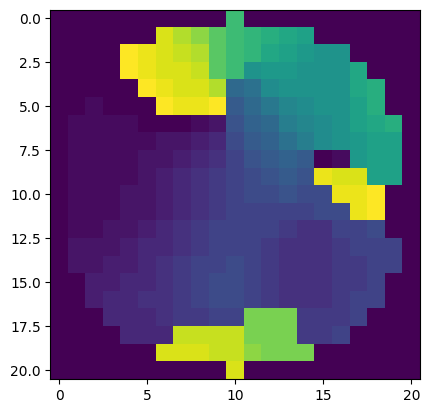

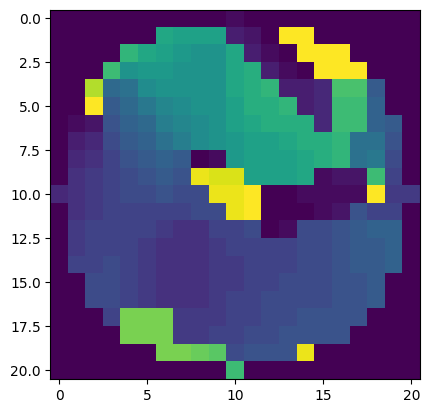

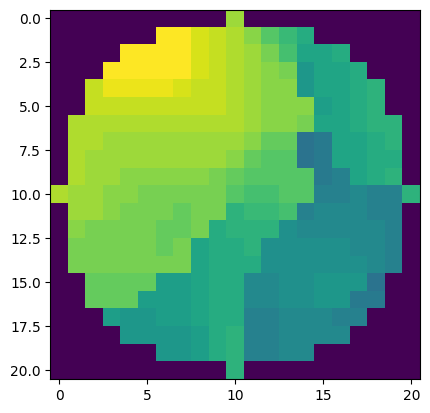

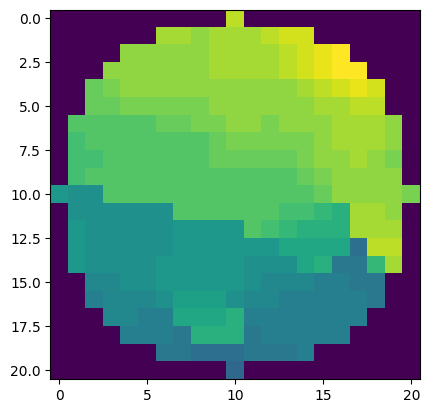

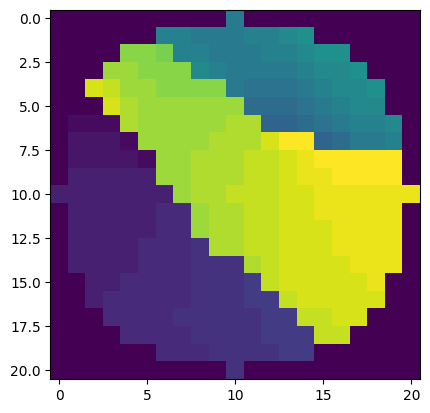

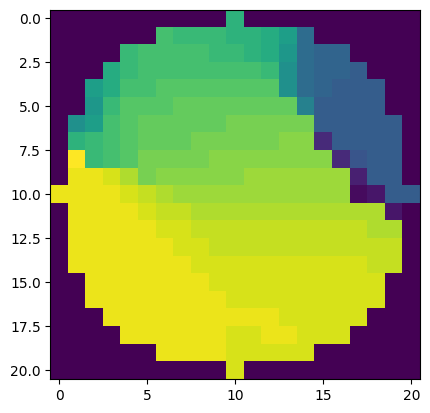

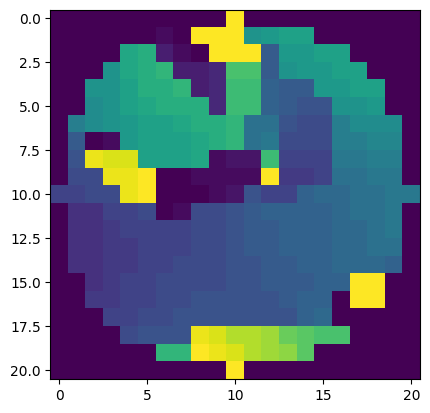

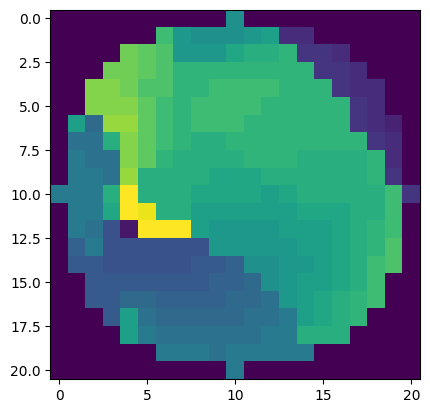

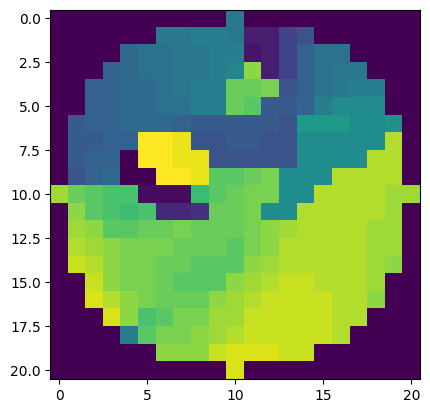

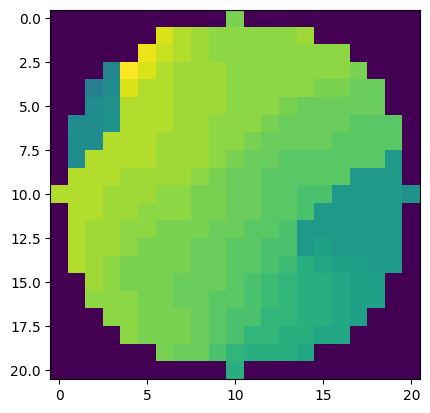

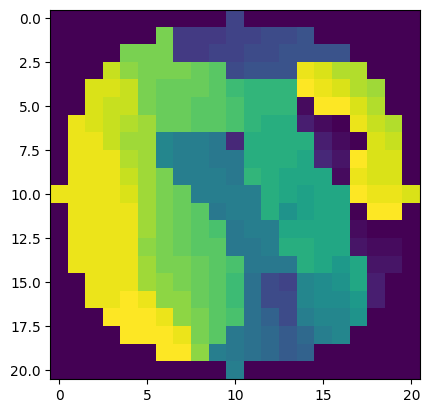

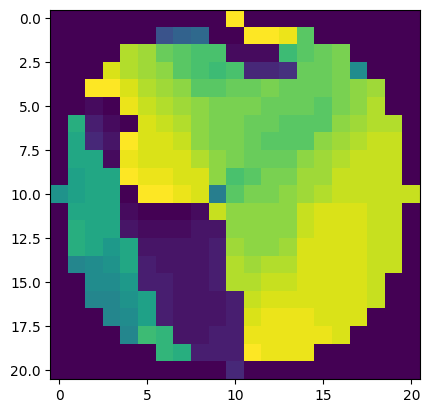

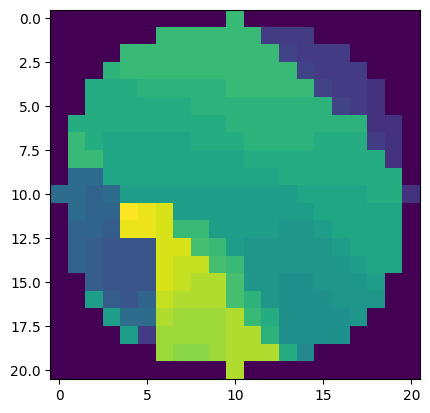

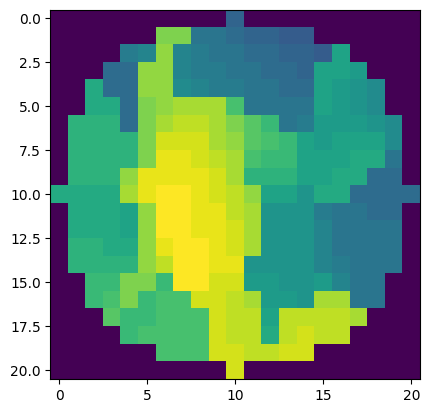

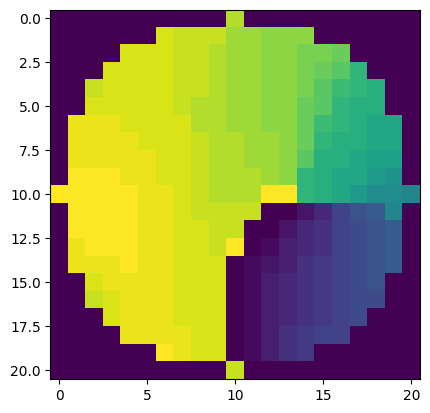

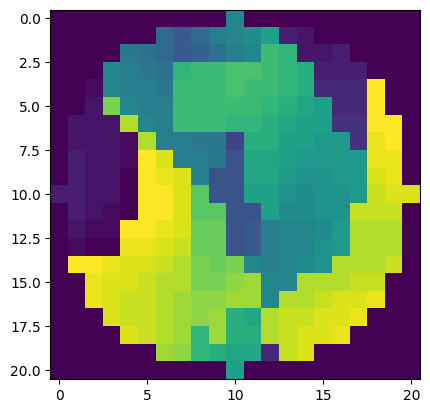

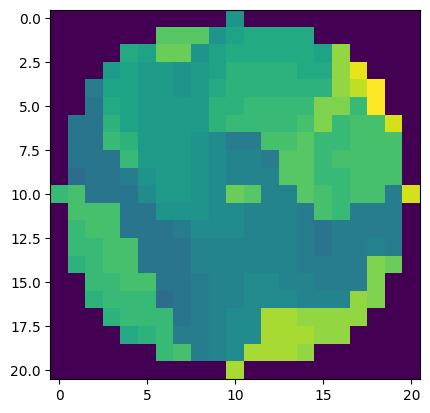

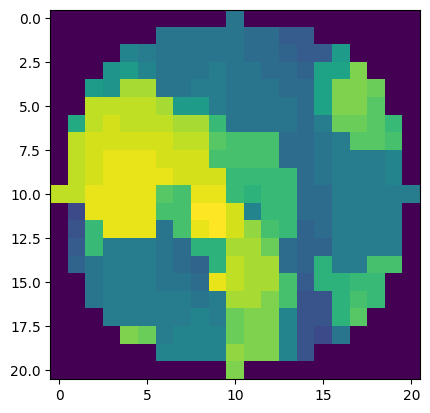

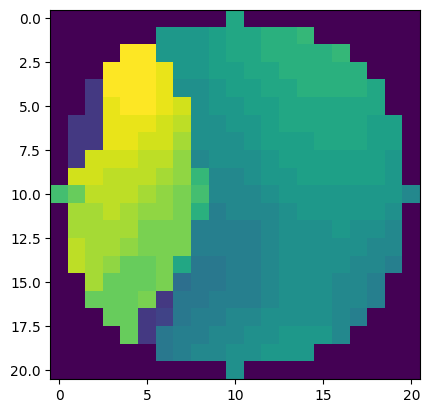

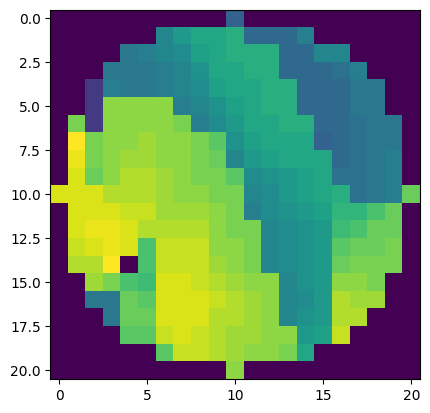

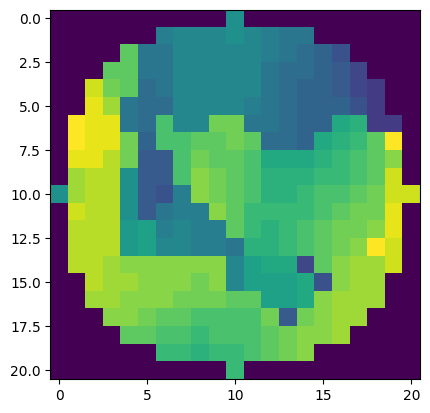

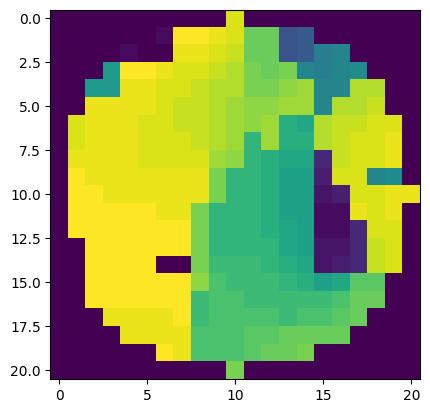

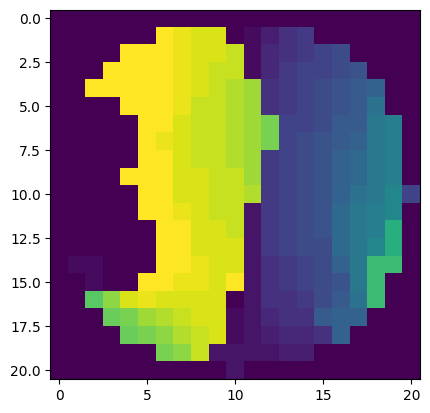

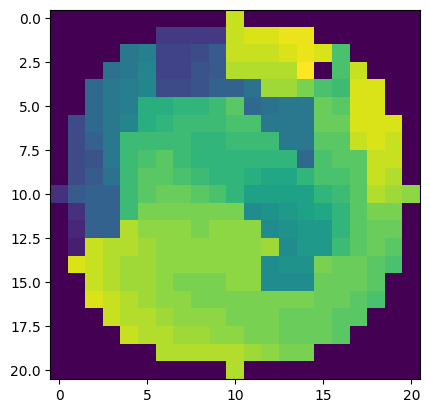

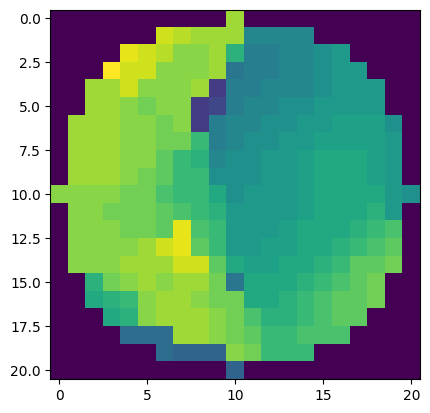

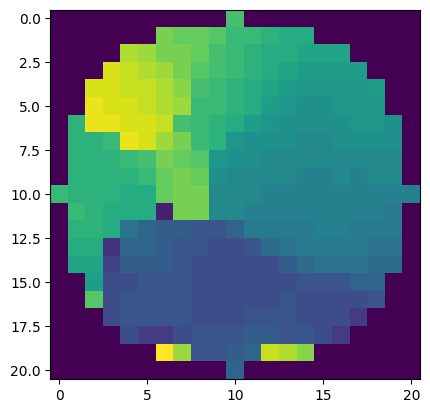

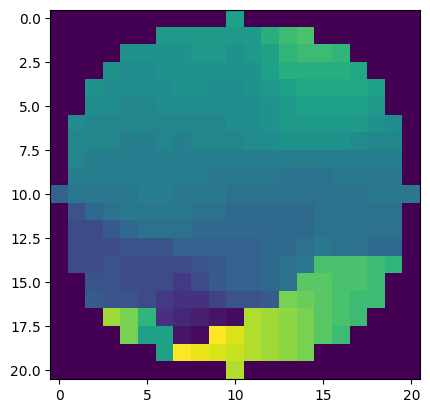

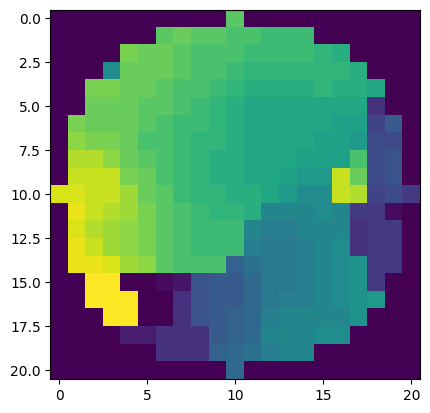

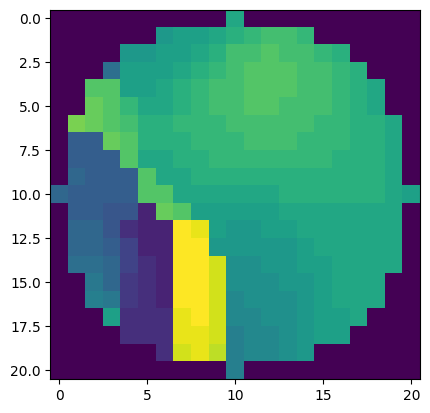

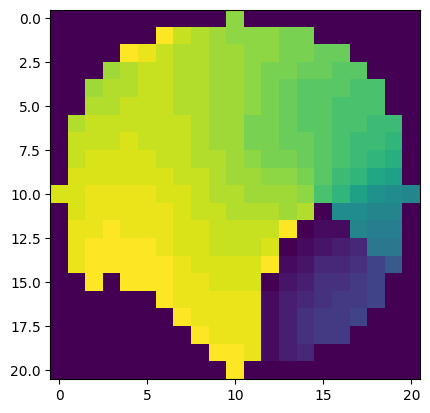

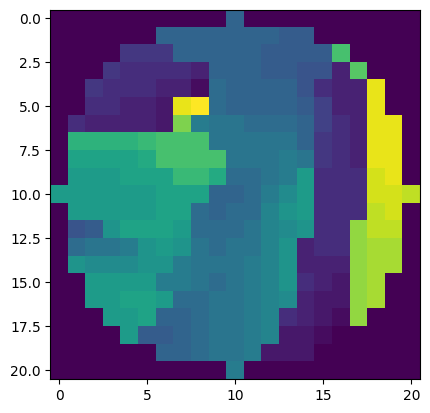

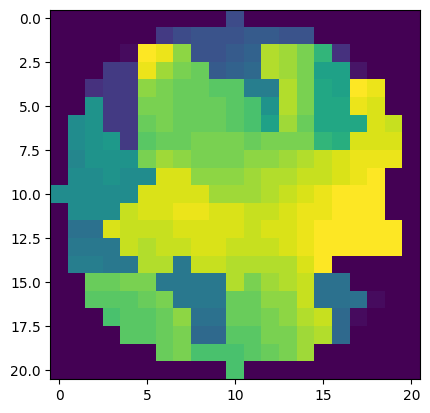

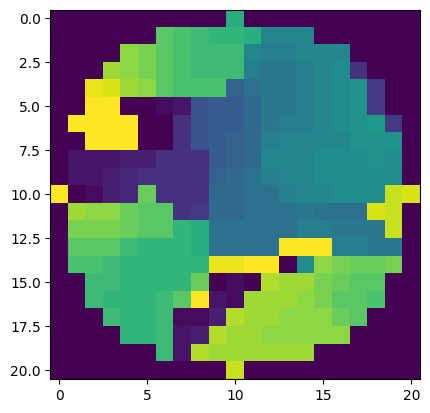

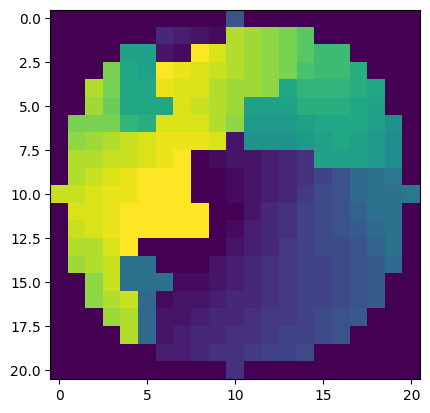

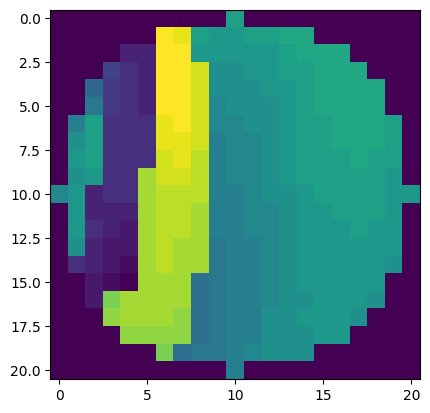

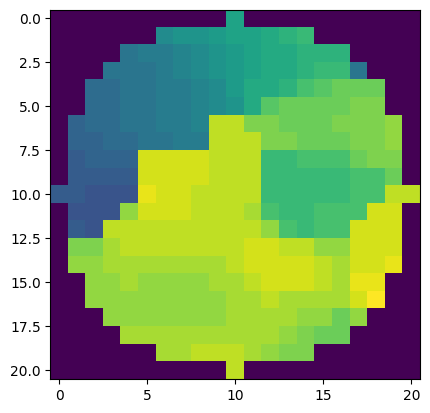

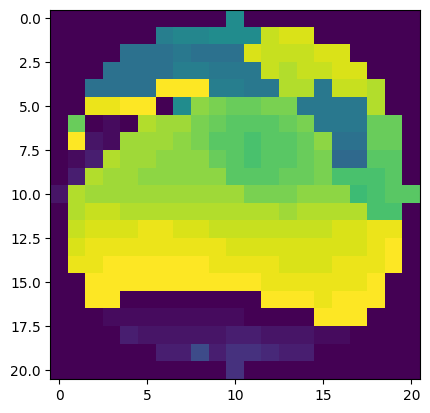

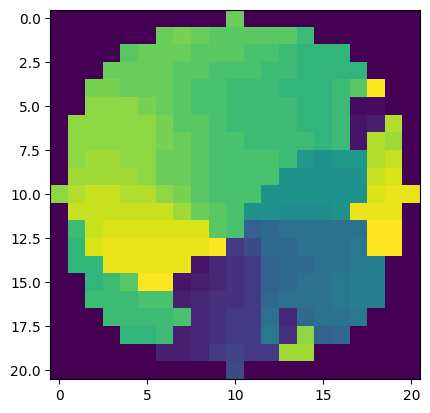

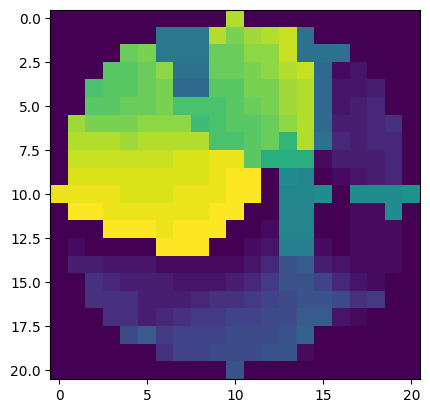

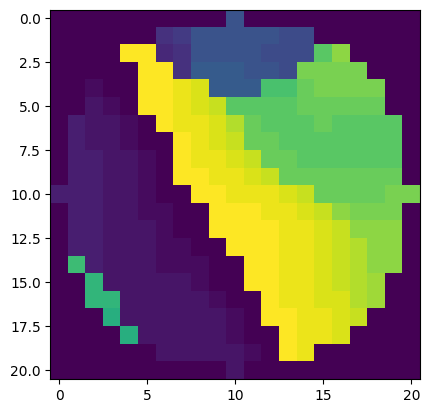

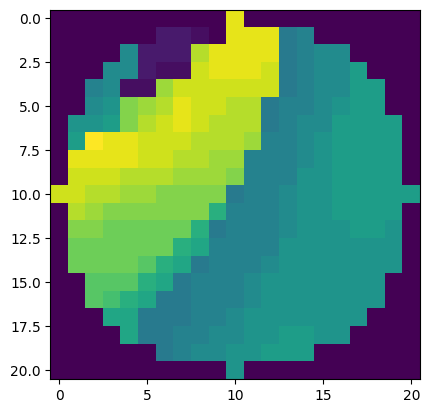

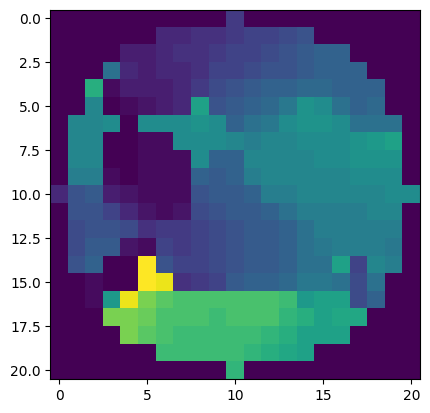

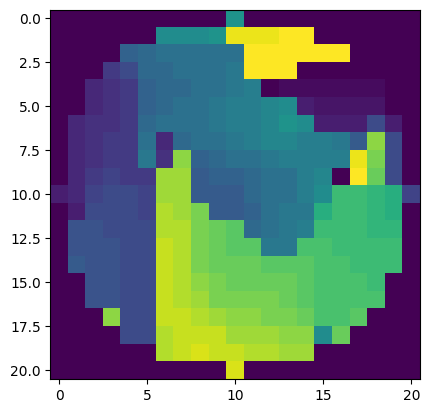

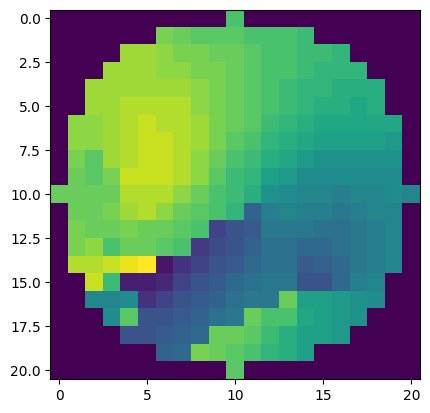

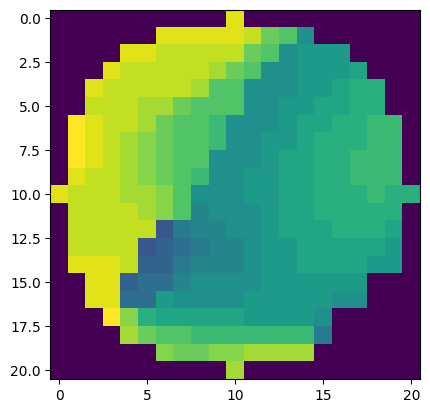

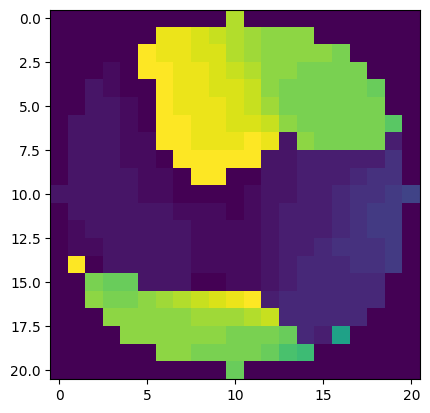

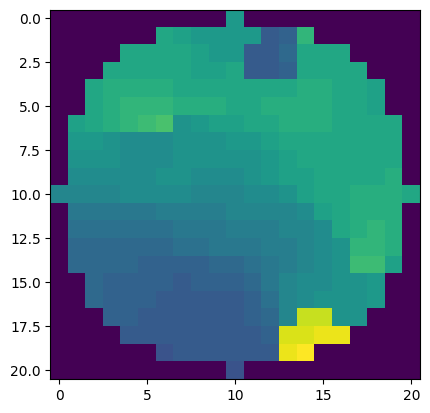

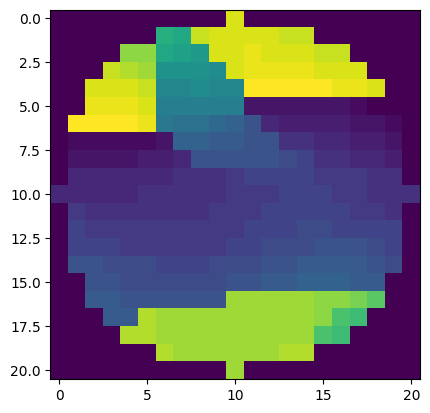

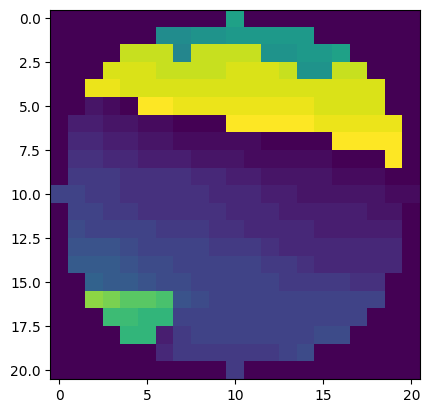

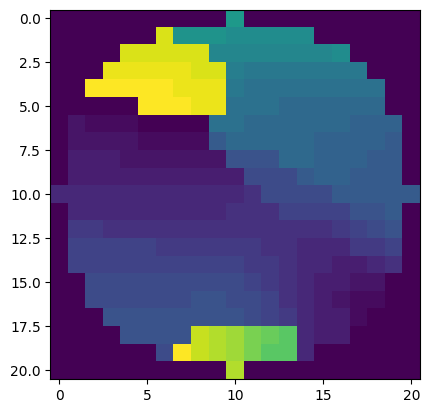

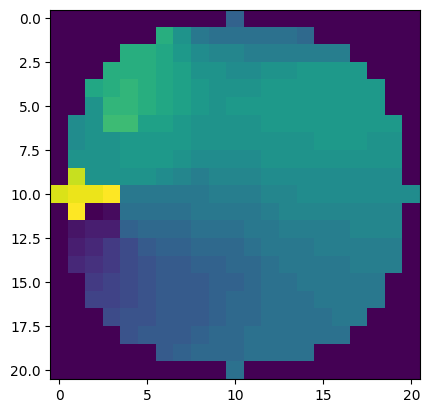

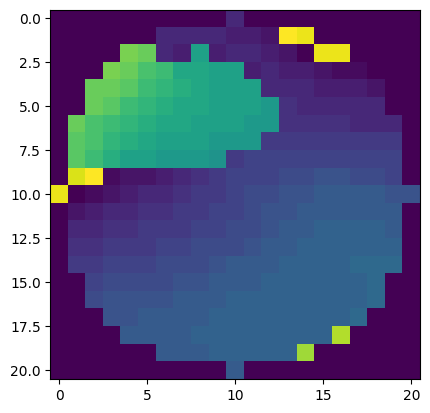

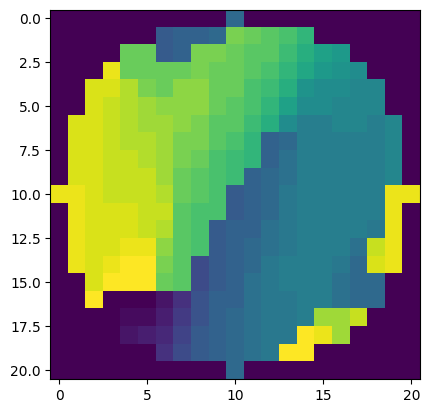

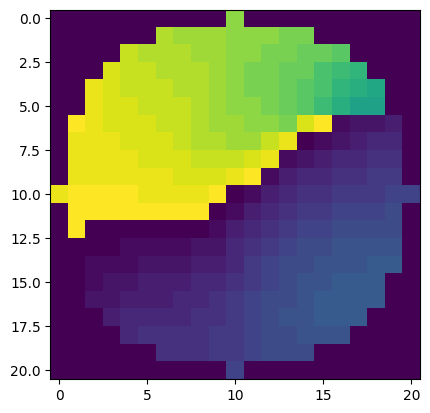

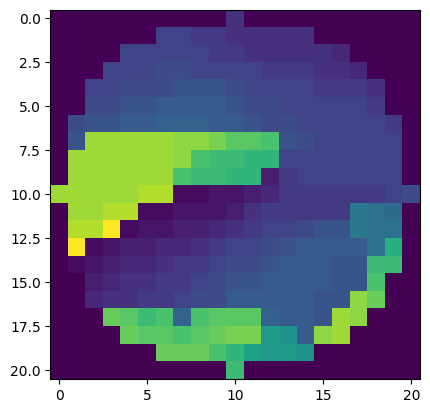

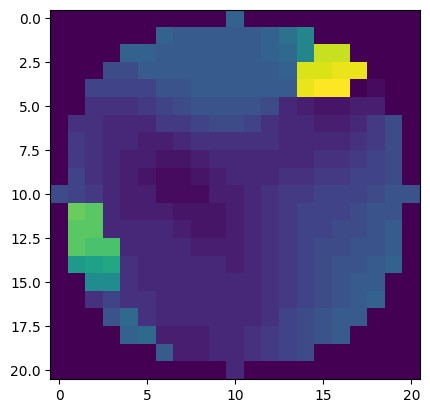

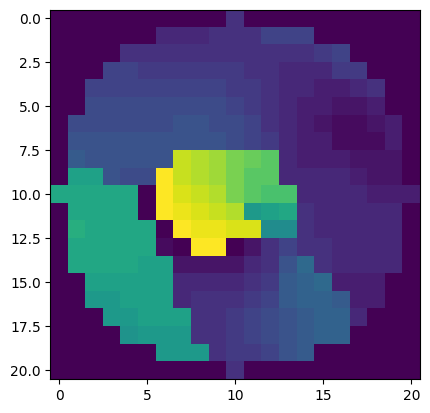

In [12]:
for i,detect in enumerate(batch_result):
    print('batch ',i,' QTD features ', len(detect))
    for j,(box,img) in enumerate(detect):
        plt.imshow(img)
        plt.show()
    break

In [13]:
from e2cnn import gspaces, nn
r2_act = gspaces.Rot2dOnR2(N=args.group_size)
feat_type_ori_est = nn.FieldType(r2_act, [r2_act.regular_repr])
pool_max = nn.PointwiseMaxPoolAntialiased(feat_type_ori_est,kernel_size=2)

In [14]:
feat_type_ori_est

[36-Rotations: {regular}]

In [15]:
img_temp = batch_result[0][0][1]
_orie1.shape

torch.Size([8, 36, 180, 180])

torch.Size([8, 36, 180, 180])
torch.Size([36, 25, 20])


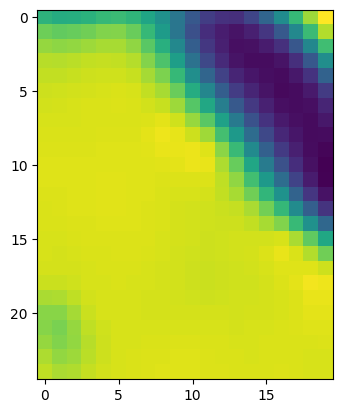

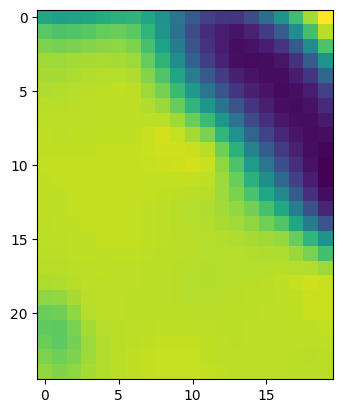

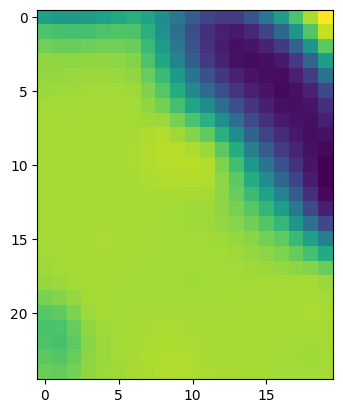

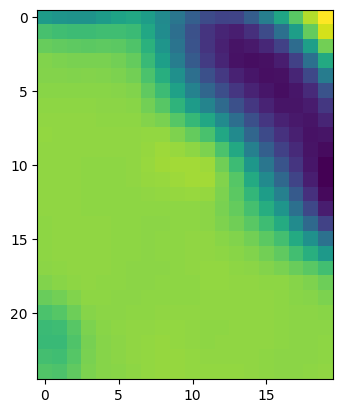

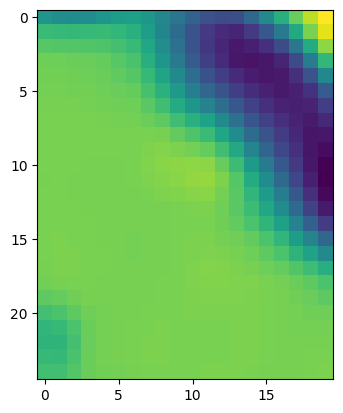

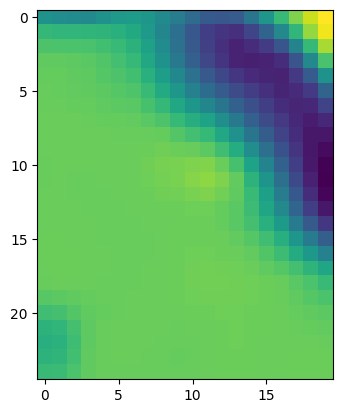

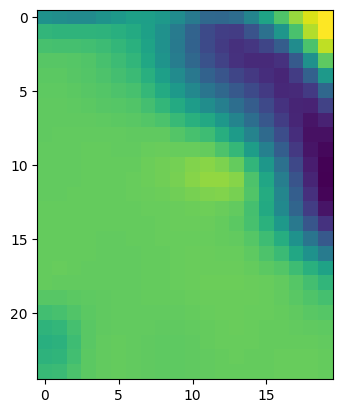

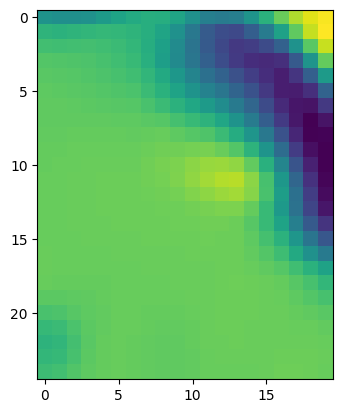

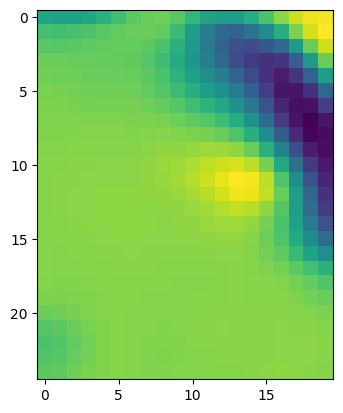

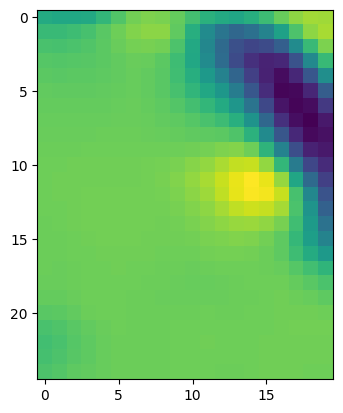

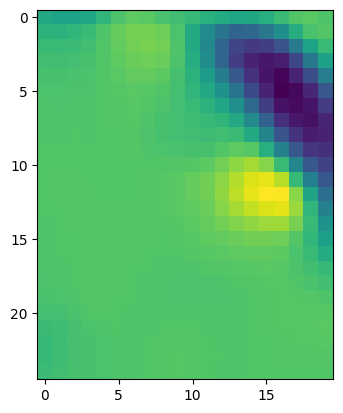

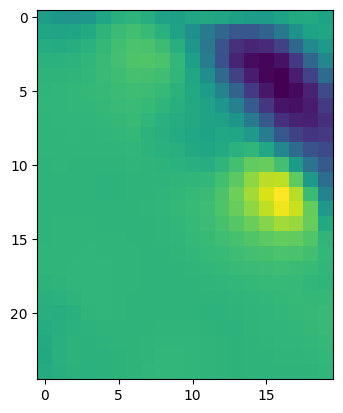

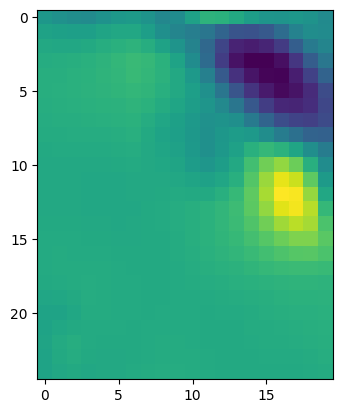

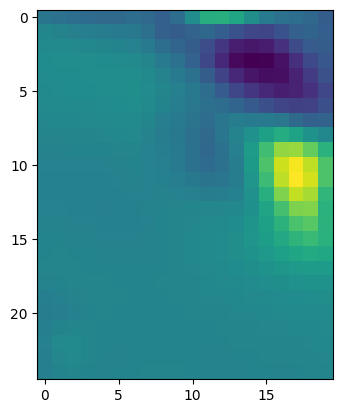

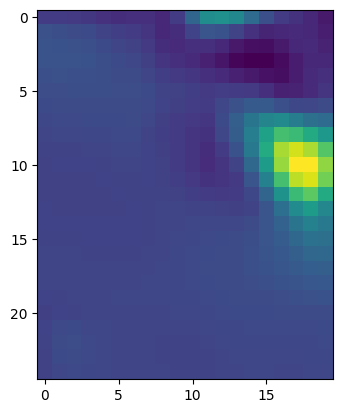

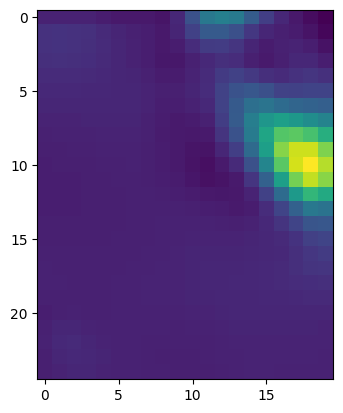

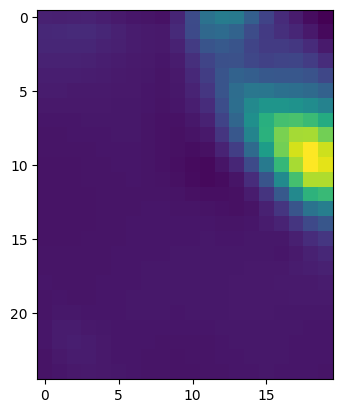

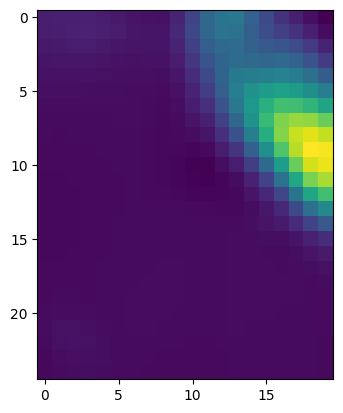

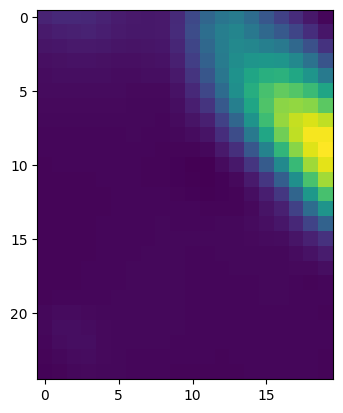

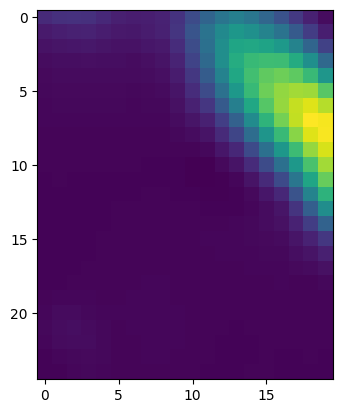

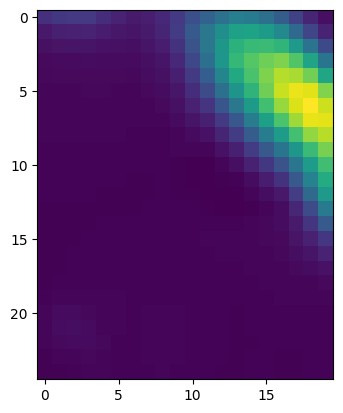

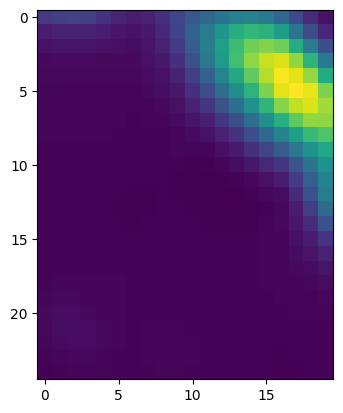

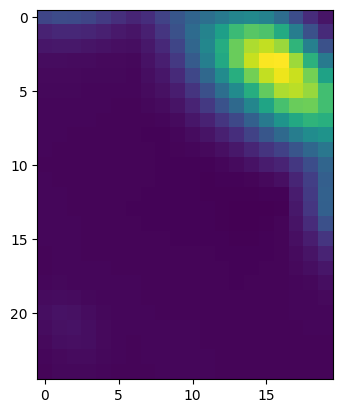

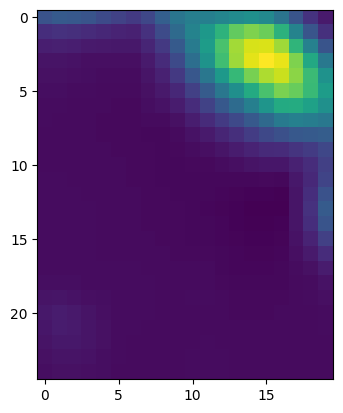

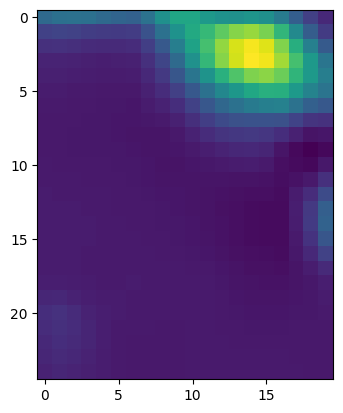

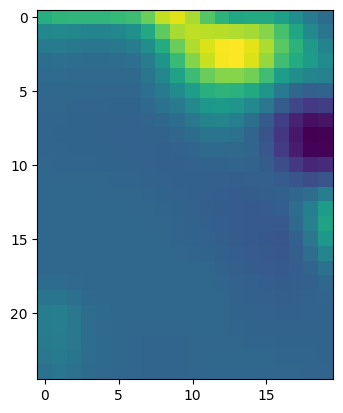

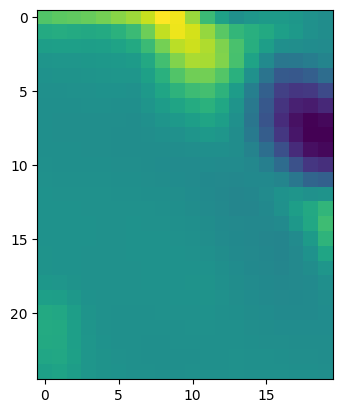

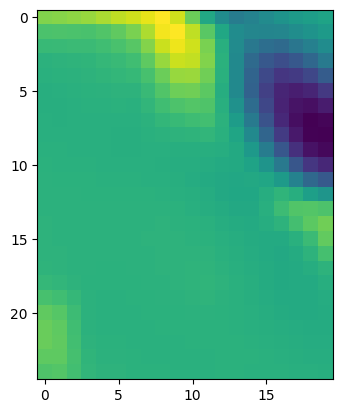

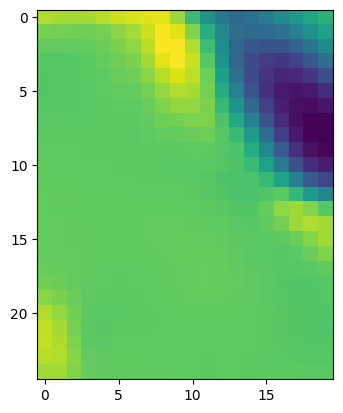

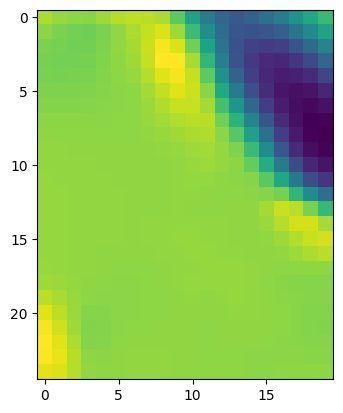

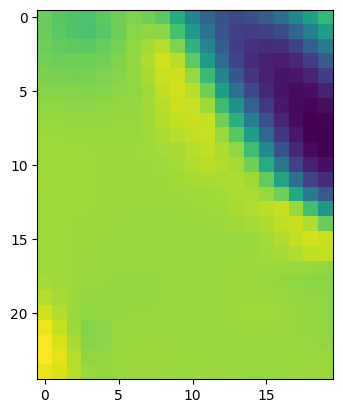

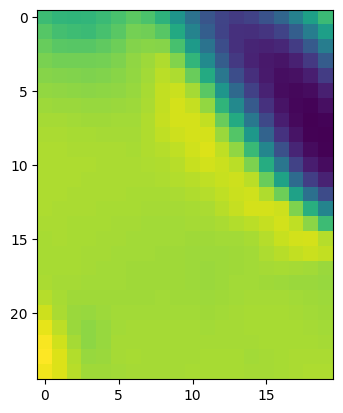

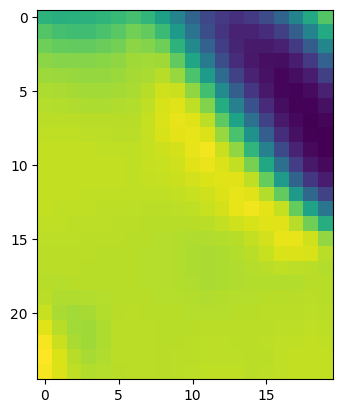

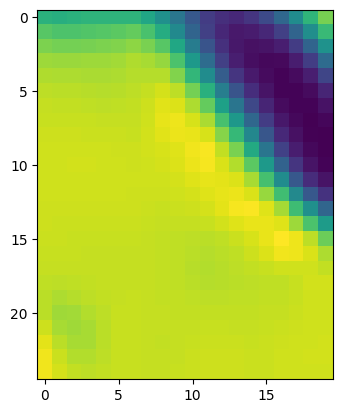

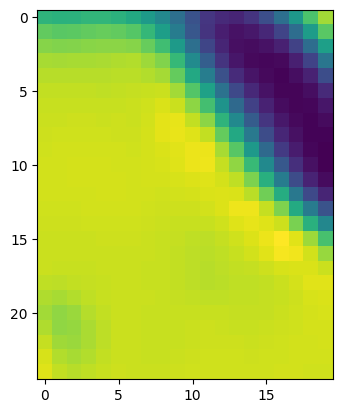

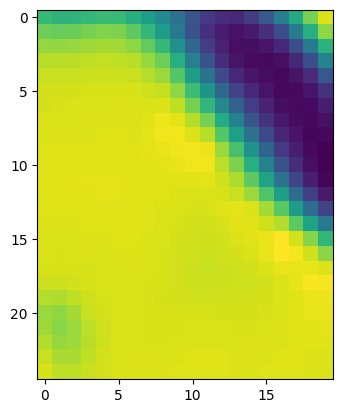

In [16]:
g_size = _orie1.shape[1]
print(_orie1.shape)
filtro = _orie1[0,:,25:50,100:120]
print(filtro.shape)
for i in range(g_size):
    plt.imshow(filtro[i].cpu().detach())
    plt.show()